In [1]:
import os

import numpy as np
import pickle
import time

from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import GPy
import optunity as opt
import sobol as sb

import scipy.stats as stats

import matplotlib.pyplot as plt

In [2]:
retrain = True

# Data

In [3]:
with open('../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (2488918, 33)
y_train.shape = (2488918, 2)


# Parameter Optimization

In [5]:
RandomForestClassifier_parameters = {
    'n_jobs': 8,                # use 8 cores
    'random_state': 20210927    # with the same random state
}

In [6]:
hyperparameter_search_space_boundaries = {
    'n_estimators': [1, 100],
}

## Cross-Validation: Helper Functions

In [ ]:
def scale_hyperparameters(hyperparameters):
    return np.array([h * (boundaries[1] - boundaries[0]) + boundaries[0] for h, boundaries in zip(hyperparameters, hyperparameter_search_space_boundaries.values())])

In [7]:
def get_mean_CV_Score(score_function, hyperparameters, y_label):
    assert y_label in ['hosp', 'death']
    y_index = 0 if y_label == 'hosp' else 1

    n_estimators, = hyperparameters

    kf = KFold(n_splits=5, shuffle=True, random_state=20210927)

    log_loss_list = np.empty(5, dtype=np.float64)

    for split_index, (fit_index, val_index) in enumerate(kf.split(X_train)):
        # create splits
        X_fit, X_val = X_train[fit_index], X_train[val_index]
        y_fit, y_val = y_train[fit_index], y_train[val_index]

        # scale features
        sc_X_fit = StandardScaler()
        X_fit_scaled = sc_X_fit.fit_transform(X_fit)
        X_val_scaled = sc_X_fit.transform(X_val)

        # create classifier
        rfc = RandomForestClassifier(**RandomForestClassifier_parameters, n_estimators=n_estimators)

        # fit
        rfc.fit(X_fit_scaled, y_fit[:, y_index])

        # evaluate
        y_pred_proba = rfc.predict_proba(X_val_scaled)
        log_loss_list[split_index] = score_function(y_val[:, y_index], y_pred_proba[:, 1])

    # also penalize n_estimators
    return np.mean(log_loss_list) + 1e-5 * np.array(n_estimators)**2

In [ ]:
def expected_improvement(n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes, gp):
    # compute E(q) and Var(q)
    E_pred, Var_pred = gp.predict_noiseless(np.array([[n_blocks, n_coupling_network_hidden_layers, n_coupling_network_hidden_nodes]]))

    # compute gamma with the STD(q)
    γ = (E_best - E_pred) / np.sqrt(Var_pred)

    # return Expected Improvement
    return (np.sqrt(Var_pred) * (γ * stats.norm.cdf(γ) + stats.norm.pdf(γ)))[0]

In [ ]:
def initialize_GP(n_samples, progress=0):
    Q_init = np.empty((n_samples, len(hyperparameter_search_space_boundaries)))
    E_init = np.empty((n_samples, 1))

    # initialize with sobol sequence between 0 and 1
    for i in range(n_samples):
        for j, boundaries in enumerate(hyperparameter_search_space_boundaries.values()):
            Q_init[i, j] = sb.i4_sobol(len(hyperparameter_search_space_boundaries), i)[0][j]

    # compute scores for the initial hyperparameters
    for i, hyperparameters in enumerate(Q_init):

        # skip the ones that have already been computed
        if progress > i:
            continue

        # scale hyperparameters according to their bounds and convert them to integers
        hyperparameters_scaled = scale_hyperparameters(hyperparameters).round().astype(int)

        # print the status
        hyperparameters_dict = {key: hyperparameters_scaled[i] for i, key in enumerate(hyperparameter_search_space_boundaries.keys())}
        print(f'{i+1}/{len(Q_init)}: {hyperparameters_dict}')
        time.sleep(0.35)
        
        # compute cv score
        E_init[i, :] = get_mean_CV_Score(log_loss, hyperparameters_scaled)
        print(f'score: {E_init[i, :]}')
        progress += 1

        # save checkpoint
        print('Storing Checkpoint...')
        with open(f'../../hyperparameter_results/RF.pt', 'wb') as file:
            pickle.dump((Q_init, E_init), file)
        with open(f'../../hyperparameter_results/RF_progress.pt', 'wb') as file:
            pickle.dump(progress, file)
        print('Stored Checkpoint...')

    return Q_init, E_init

## Run Optimization

In [ ]:
initial_n_samples = 8
additional_n_samples = 24

In [8]:
GP, Q, E = {}, {}, {}
for y_label in ['hosp', 'death']:
    if retrain:

        # load checkpoint if possible
        if os.path.isfile('../../hyperparameter_results/RF.pt') and os.path.isfile('../../hyperparameter_results/RF_progress.pt'):
            print('Loading Checkpoint...')
            with open('../../hyperparameter_results/RF.pt', 'rb') as file:
                Q[y_label], E[y_label] = pickle.load(file)
            with open('../../hyperparameter_results/RF_progress.pt', 'rb') as file:
                progress = pickle.load(file)
            print('Loaded Checkpoint')
        else:
            progress = 0

        # if not all initial hyperparameters have been tested, continue testing them
        if progress < initial_n_samples:
            print(f"Initializing GP...")
            time.sleep(0.3)
            Q[y_label], E[y_label] = initialize_GP(initial_n_samples, progress=progress)
            progress = initial_n_samples

        # main GP training loop
        print('Training GP...')
        for k in range(progress - initial_n_samples, additional_n_samples):
            # train Gaussian Process
            GP = GPy.models.GPRegression(Q[y_label], E[y_label], kernel=GPy.kern.Matern52(1))
            GP.optimize(messages=False)

            # determine E_best (minimum value of E)
            E_best = np.min(E[y_label])

            # determine q_new (q with maximum expected improvement)
            optimizer_output = opt.maximize(
                lambda **kwargs: expected_improvement(gp=GP, **kwargs),
                **{k: [0, 1] for k in hyperparameter_search_space_boundaries.keys()}
            )[0]

            # extract and scale new 'optimal' hyperparameters
            q_new = np.array([optimizer_output[k] for k in hyperparameter_search_space_boundaries.keys()]).ravel()
            q_new_scaled = scale_hyperparameters(q_new).round().astype(int)

            # only for integer values: if the new hyperparameters have already been tested, the algorithm converged
            for q in Q[y_label]:
                if (q_new == q).all():
                    print('GP Converged early.')
                    break

            # print status
            hyperparameters_dict = {key: q_new_scaled[i] for i, key in enumerate(hyperparameter_search_space_boundaries.keys())}
            print(f'{k+1}/{additional_n_samples}: {hyperparameters_dict}')
            time.sleep(0.3)

            # add q_new to the training set Q
            Q[y_label] = np.vstack((Q[y_label], q_new))

            # add value to E
            E[y_label] = np.vstack((E[y_label], get_mean_CV_Score(log_loss, q_new_scaled).reshape(-1, 1)))
            print(f'score: {E[y_label][-1, :]}')

            # save checkpoint
            progress += 1
            print('Storing Checkpoint...')
            with open(f'../../hyperparameter_results/RF.pt', 'wb') as file:
                pickle.dump((Q[y_label], E[y_label]), file)
            with open(f'../../hyperparameter_results/RF_progress.pt', 'wb') as file:
                pickle.dump(progress, file)
            print('Stored Checkpoint...')
    else:
        print(f'Loading Results ({y_label})...')
        with open(f'../hyperparameter_results/RF_{y_label}.pt', 'rb') as file:
            Q[y_label], E[y_label] = pickle.load(file)
        print(f'Loaded Results ({y_label})')

    GP[y_label] = GPy.models.GPRegression(Q[y_label], E[y_label], kernel=GPy.kern.Matern52(1))
    GP[y_label].optimize(messages=False);

Loading Results (hosp)...
Loaded Results (hosp)
Loading Results (death)...
Loaded Results (death)


## GP-Prediction

In [10]:
n_estimators_linspace = np.linspace(np.min(hyperparameter_search_space['n_estimators']) * 0.9, np.max(hyperparameter_search_space['n_estimators']) * 1.1, 1000)

# GP_predicted_log_loss_mean, GP_predicted_log_loss_std = {}, {}
# for y_label in ['hosp', 'death']:
#     GP_predicted_log_loss_mean[y_label], GP_predicted_log_loss_var = GP[y_label].predict_noiseless(n_estimators_linspace.reshape(-1, 1))
#     GP_predicted_log_loss_std[y_label] = np.sqrt(GP_predicted_log_loss_var)

## Find 'Best' Hyperparameter

In [9]:
# def GP_log_loss_upper_confidence_bound(n_estimators, gp):
#     mean, var = gp.predict_noiseless(np.array([[n_estimators]]))
#     return mean + np.sqrt(var)

In [10]:
# GP_best_hyperparameter_prediction = {}
# for y_label in ['hosp', 'death']:
#     GP_best_hyperparameter_prediction[y_label] = opt.minimize(
#         lambda **kwargs: GP_log_loss_upper_confidence_bound(gp=GP[y_label], **kwargs),
#         n_estimators=hyperparameter_search_space_boundaries['n_estimators']
#     )[0]

# hyperparameter_best_upper_confidence_bound = {
#     y_label: {
#         'n_estimators': np.exp(GP_best_hyperparameter_prediction[y_label]['n_estimators'])
#     }
#     for y_label in ['hosp', 'death']
# }

## GP-Crossvalidation Results

[0.62110306 0.49788362 0.44115696 0.42824351 0.42108401 0.42878162
 0.49506583 0.78621468]
[0.05739974 0.04581502 0.04141292 0.04103885 0.04347286 0.06380487
 0.13859725 0.4383046 ]


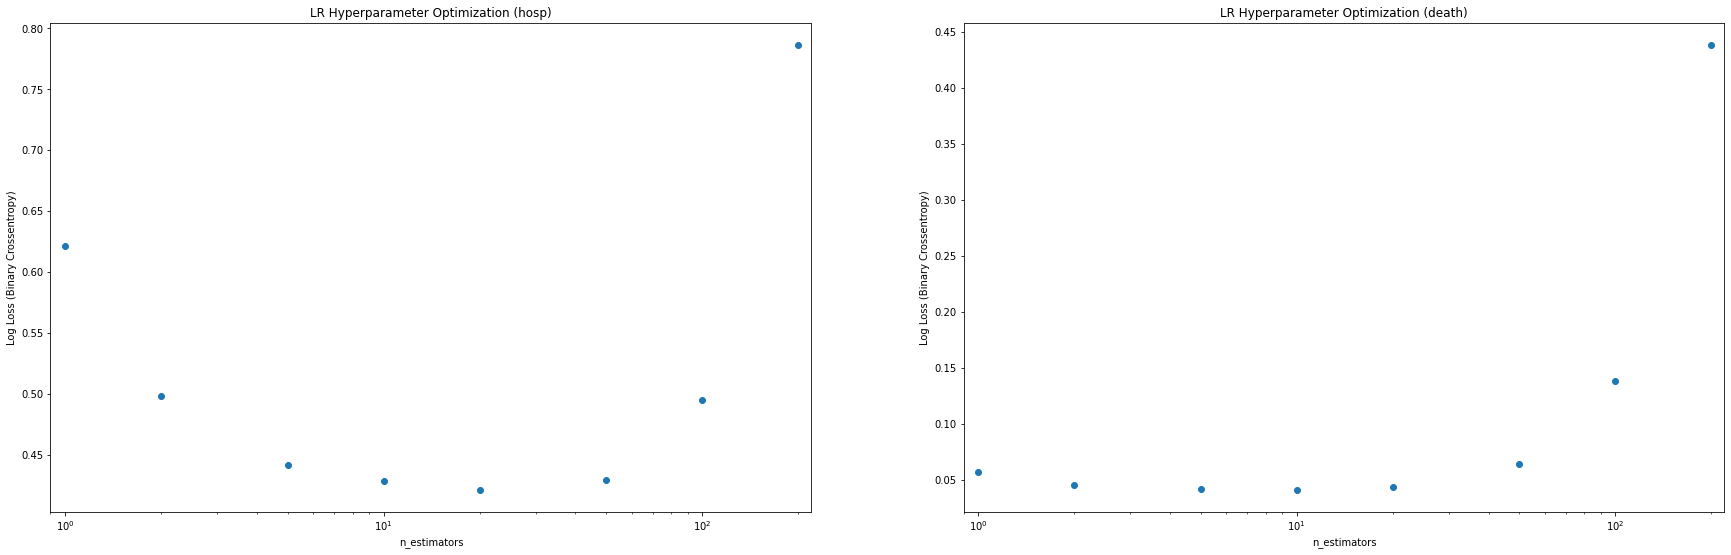

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(30, 9))

for i, y_label in enumerate(['hosp', 'death']):
    axes[i].scatter(Q[y_label], np.array(E[y_label]) + 1e-5 * np.array(Q[y_label])**2, color='tab:blue')
    print(np.array(E[y_label]) + 1e-5 * np.array(Q[y_label])**2)
    # axes[i].scatter(np.exp(Q[y_label][10:, 0]), E[y_label][10:, 0], color='tab:blue', label='Trained GP')

    # axes[i].plot(n_estimators_linspace, GP_predicted_log_loss_mean[y_label][:, 0], color='black', alpha=0.5, label=r'Predicted Log Loss by GP ($\pm$ STD)')
    # axes[i].fill_between(n_estimators_linspace, GP_predicted_log_loss_mean[y_label][:, 0] - GP_predicted_log_loss_std[y_label][:, 0], GP_predicted_log_loss_mean[y_label][:, 0] + GP_predicted_log_loss_std[y_label][:, 0], color='black', alpha=0.2)

    # axes[i].axvline(hyperparameter_best_upper_confidence_bound[y_label]['n_estimators'], color='tab:green', label=r'$N_{\mathrm{est.}}$ =' + f' {np.round(hyperparameter_best_upper_confidence_bound[y_label]["n_estimators"], 3)} (Best Upper Confidence Bound)')

    axes[i].set_xscale('log'); axes[i].set_xlim(np.min(n_estimators_linspace), np.max(n_estimators_linspace))
    axes[i].set_xlabel('n_estimators'); axes[i].set_ylabel('Log Loss (Binary Crossentropy)'); axes[i].set_title(f'LR Hyperparameter Optimization ({y_label})')
    # axes[i].legend();

# Final Training

In [12]:
# scale features
sc_X_train = StandardScaler()
X_train_scaled = sc_X_train.fit_transform(X_train)

# create classifier
rfc = {y_label: RandomForestClassifier(**RandomForestClassifier_parameters, n_estimators=100) for y_label in ['hosp', 'death']}

# fit
for i, y_label in enumerate(tqdm(['hosp', 'death'])):
    rfc[y_label].fit(X_train_scaled, y_train[:, i]);

100%|██████████| 2/2 [07:59<00:00, 239.66s/it]


# Evaluation on Test Set

In [13]:
with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test_scaled = sc_X_train.transform(X_test)

X_test.shape = (630290, 28)
y_test.shape = (630290, 2)


In [14]:
evaluation_results = {}

for i, y_label in enumerate(['hosp', 'death']):
    print(f'--- {y_label} ---')

    y_pred_proba = rfc[y_label].predict_proba(X_test_scaled)
    evaluation_results[y_label] = y_pred_proba
    y_pred = rfc[y_label].predict(X_test_scaled)

    print(f'binary cross-entropy: {np.round(log_loss(y_test[:, i], y_pred_proba[:, 1]), 4)}')
    print(f'brier loss: {brier_score_loss(y_test[:, i], y_pred_proba[:, 1]).round(4)}')
    print(f'accuracy: {accuracy_score(y_test[:, i], y_pred).round(4)}')
    print('confusion matrix:')
    print(confusion_matrix(y_test[:, i], y_pred))
    print()

--- hosp ---
binary cross-entropy: 0.3636
brier loss: 0.0547
accuracy: 0.9343
confusion matrix:
[[581891   3731]
 [ 37708   6960]]

--- death ---
binary cross-entropy: 0.0352
brier loss: 0.0093
accuracy: 0.9887
confusion matrix:
[[621176    310]
 [  6819   1985]]



In [15]:
with open('../evaluation_results/models/RF.pt', 'wb') as file:
    pickle.dump(evaluation_results, file)

# Observations

more false negatives than false positives. Slightly better accuracy than SVC and LR.